<a href="https://colab.research.google.com/github/yeb2Binfang/sklearn_learning/blob/main/decision_tree/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Titanic - Machine Learning from Disaster
泰坦尼克号的沉没是世界上最严重的海难事故之一，今天我们通过分类树模型来预测一下哪些人可能成为幸存者。数据集来自https://www.kaggle.com/c/titanic
数据集包含两个csv格式文件，data为我们接下来要使用的数据，test为kaggle提供的测试集。
我已经把data uploaded到github了，可以直接用

data:https://raw.githubusercontent.com/yeb2Binfang/sklearn_learning/main/decision_tree/Titanic_data.csv

test: https://raw.githubusercontent.com/yeb2Binfang/sklearn_learning/main/decision_tree/Titanic_test.csv

import some necessary packages


In [28]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

##get the data

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/yeb2Binfang/sklearn_learning/main/decision_tree/Titanic_data.csv")
df[0:5]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


我们要去查看数据，看看有没有缺失的啊，看看有没有哪些features是没用的啊之类的

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


##数据预处理
删除不需要的，删除一些缺失值很多的，补缺失值

In [7]:
#删除缺失值过多的，删除不需要的features
df.drop(["Cabin","Name","Ticket","PassengerId"], inplace=True, axis=1)

In [8]:
df[0:5]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [9]:
#处理缺失值，对缺失值较多的列进行填补，对年龄来说，缺失值可以用平均值
#可以去了解一下怎么去不缺失值
df["Age"] = df["Age"].fillna(df["Age"].mean())

#我们注意到，Embarked那里，缺失了两个数值，影响不大，可以删掉
df = df.dropna()

In [10]:
#接下来是将二分类变量转换为数值型的变量
#比如说，male and female, 可以转换成0,1
#可以用astype
df["Sex"] = (df["Sex"]=="male").astype("int")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [15]:
#将三分类变量转换为数值型变量
#我们可以先去看看看Embarked的数据是怎么样的
labels = df["Embarked"].unique().tolist()
print(labels)
#我们可以看到Embarked有三个变量，所以要进行转换
df["Embarked"] = df["Embarked"].apply(lambda x: labels.index(x))

['S', 'C', 'Q']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.000000,1,0,7.2500,0
1,1,1,0,38.000000,1,0,71.2833,1
2,1,3,0,26.000000,0,0,7.9250,0
3,1,1,0,35.000000,1,0,53.1000,0
4,0,3,1,35.000000,0,0,8.0500,0
...,...,...,...,...,...,...,...,...
886,0,2,1,27.000000,0,0,13.0000,0
887,1,1,0,19.000000,0,0,30.0000,0
888,0,3,0,29.699118,1,2,23.4500,0
889,1,1,1,26.000000,0,0,30.0000,1


##提取标签和特征矩阵，分测试集和训练集


In [19]:
#我们要提取target column and features columns
#features columns
#df.iloc[rows,cols]
X = df.iloc[:,df.columns != "Survived"]
y = df.iloc[:,df.columns == "Survived"]

print(X[0:5])
print(y[0:5])

   Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
0       3    1  22.0      1      0   7.2500         0
1       1    0  38.0      1      0  71.2833         1
2       3    0  26.0      0      0   7.9250         0
3       1    0  35.0      1      0  53.1000         0
4       3    1  35.0      0      0   8.0500         0
   Survived
0         0
1         1
2         1
3         1
4         0


分测试集合训练集


In [20]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)
#因为是随机选取的，所以要修正下索引
for i in[X_train,X_test,y_train,y_test]:
  i.index = range(i.shape[0])

X_train[0:5]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,1,25.0,1,0,55.4417,1
1,3,1,51.0,0,0,7.0542,0
2,1,1,38.0,0,1,153.4625,0
3,3,1,35.0,0,0,7.8958,1
4,3,0,48.0,1,3,34.3750,0


##import the model and see the result

In [23]:
clf = DecisionTreeClassifier(random_state=25)
clf.fit(X_train,y_train)
score = clf.score(X_test,y_test)
print("the accuracy is : {0:2.5f}".format(score))

the accuracy is : 0.77528


##adjust the parameters to improve acc
The accuracy is so low that we need to adjust the parameters to improve it

In [35]:
#看train_score是因为怕过拟合
train_score = []
test_score = []

for i in range(10):
  clf = DecisionTreeClassifier(random_state=25
                               ,max_depth = i+1
                               ,criterion = "entropy"
                              )
  clf.fit(X_train,y_train)
  score_tr = clf.score(X_train, y_train)
  score_te = cross_val_score(clf, X, y,cv=10).mean()
  train_score.append(score_tr)
  test_score.append(score_te)
print(max(test_score))

0.8177860061287026


In [36]:
te_score = np.array(test_score)
im = np.argmax(te_score)
best_depth = range(1,11)[im]
print("the best max-depth is: {0:1d}".format(best_depth))

the best max-depth is: 7


visualize the result


<function matplotlib.pyplot.show>

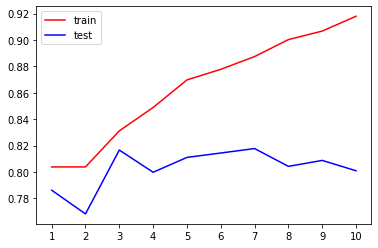

In [37]:
plt.plot(range(1,11),train_score, color='r',label="train")
plt.plot(range(1,11),test_score, color='b',label="test")
plt.xticks(range(1,11))
plt.legend()
plt.show

##用网格搜索调整参数
就是有多个参数要调整，然后放在一个dict，进行每一个参数进行调整
用GridSearchCV.但是这样很耗时间，所以当使用这个的时候，心中要有区间范围

In [43]:
gini_thresholds = np.linspace(0,0.5,20)
parameters = {"splitter":('best','random')
              ,'criterion':("gini",'entropy')
              ,'max_depth':[*range(1,10)]
              ,'min_samples_leaf':[*range(1,20,5)]
              ,'min_impurity_decrease':[*np.linspace(0,0.5,20)]
             }

clf = DecisionTreeClassifier(random_state=25)
GS = GridSearchCV(clf, parameters, cv=10)
GS.fit(X_train,y_train)




GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=25,
                                              splitter='best'),
             iid='dep...
                                                   0.21052631578947367,
                          

In [41]:
[*range(1,20,5)]

[1, 6, 11, 16]

把参数打印出来

In [44]:
print(GS.best_params_)
print(GS.best_score_)


{'criterion': 'gini', 'max_depth': 6, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 6, 'splitter': 'best'}
0.8359959037378392


我们可以看到还是由提升这么一丢丢的

In [47]:
clf = DecisionTreeClassifier(random_state=25, criterion='gini',max_depth=6,min_impurity_decrease=0.0,min_samples_leaf=6,splitter='best')
clf.fit(X_train,y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test,y_test))


0.8729903536977492
0.8202247191011236


##real test dataset
我们把这个模型放在真正的测试集上，也就是kaggle提供的test dataset，我们看看结果怎么样

In [48]:
df = pd.read_csv("https://raw.githubusercontent.com/yeb2Binfang/sklearn_learning/main/decision_tree/Titanic_test.csv")
df[0:5]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


我们得对test dataset进去数据预处理

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [51]:
#删除缺失值过多的，删除不需要的features
df.drop(["Cabin","Name","Ticket","PassengerId"], inplace=True, axis=1)

#处理缺失值，对缺失值较多的列进行填补，对年龄来说，缺失值可以用平均值
#可以去了解一下怎么去不缺失值
df["Age"] = df["Age"].fillna(df["Age"].mean())

#我们注意到，Fare那里，缺失了1个数值，影响不大，可以删掉
df = df.dropna()

In [52]:
#接下来是将二分类变量转换为数值型的变量
#比如说，male and female, 可以转换成0,1
#可以用astype
df["Sex"] = (df["Sex"]=="male").astype("int")

#将三分类变量转换为数值型变量
#我们可以先去看看看Embarked的数据是怎么样的
labels = df["Embarked"].unique().tolist()
print(labels)
#我们可以看到Embarked有三个变量，所以要进行转换
df["Embarked"] = df["Embarked"].apply(lambda x: labels.index(x))

['Q', 'S', 'C']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


数据有点问题，没有survived那个column

In [53]:
df[0:5]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,34.5,0,0,7.8292,0
1,3,0,47.0,1,0,7.0000,1
2,2,1,62.0,0,0,9.6875,0
3,3,1,27.0,0,0,8.6625,1
4,3,0,22.0,1,1,12.2875,1
